In [ ]:
#!pip install pyswarms

Import packages

In [4]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))
import pandas as pd
from configparser import ConfigParser
from repo.MyConfigParser import MyConfigParser
from repo.Optimization import SavantPSO
import numpy as np

# Read In

Import the config file and set the config dict. set some variables from the config dict

In [5]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/ca/1 June Update/config ups ca.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']
optimization_start_date = config_dict['PROPHETSETTING']['optimization_start_date']
optimization_end_date = config_dict['PROPHETSETTING']['optimization_end_date']

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]

base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]
breakdown_ls = [config_dict['CLIENTINFO'][i] for i in [f'breakdown{i}' for i in range(1,5)] if config_dict['CLIENTINFO'][i] != None]

small_market_str = ''
pre_forecast_period_budget = float(config_dict['CLIENTINFO']['pre_forecast_period_budget'])
client_budget = float(config_dict['CLIENTINFO']['client_budget'])

save_date = config_dict['CLIENTINFO']['save_date']

# Read data

Read the cuts df, hyper parameter table 

In [6]:

bdDf = pd.read_csv(base_path+'New_Cuts_df.csv',index_col = False) # read the new_cuts_df.csv file 
cuts_df = bdDf
cuts_df.columns

Index(['market', 'account_type', 'funnel', 'periods_for_acc_cal',
       'changepoint_prior_scale', 'seasonality_prior_scale',
       'holidays_prior_scale', 'seasonality_mode', 'input_mode',
       'weekday_or_weekend', 'include_holiday', 'covid_year_exclude',
       'covid_year_dummy', 'anomaly_2021', 'generic_cost_split',
       'competitor_cost_split', 'new_confirmed', 'power', 'growth', 'periods',
       'cutoff_month'],
      dtype='object')

In [7]:
# create a variable with the name of the pickle file
if 'market' in cuts_df.columns and 'account_type' in cuts_df.columns and 'funnel' in cuts_df.columns:
    cuts_df['forecaster_name_list'] = cuts_df['market'] + ' ' + cuts_df['account_type'] + ' ' + cuts_df['funnel'] + '.pkl'
    cuts_df['periods'] = periods  # create the variable with the number of periods to forecast
else:
    missing_columns = [col for col in ['market', 'account_type', 'funnel'] if col not in cuts_df.columns]
    print(f"Error: missin_columns: {missing_columns}")


get the list od pickle files 

In [8]:
# get model list
forecasters_array = cuts_df.forecaster_name_list
forecasters_array

0        Canada - Brand.pkl
1    Canada - Non_Brand.pkl
Name: forecaster_name_list, dtype: object

In [9]:
cuts_df

,market,account_type,funnel,periods_for_acc_cal,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,...,covid_year_dummy,anomaly_2021,generic_cost_split,competitor_cost_split,new_confirmed,power,growth,periods,cutoff_month,forecaster_name_list
0,Canada,-,Brand,183,0.001,0.075,10.0,additive,multiplicative,additive,...,na,na,na,na,na,na,logistic,251.0,2024-04-25,Canada - Brand.pkl
1,Canada,-,Non_Brand,183,0.001,0.050,0.1,multiplicative,additive,multiplicative,...,na,na,na,na,na,na,linear,251.0,2024-04-25,Canada - Non_Brand.pkl


import the analytical file 

In [10]:
# Get analytical file
analytical_file = pd.read_csv(analytical_file_path)# read the analytical file .csv 
analytical_file['ds'] = pd.to_datetime(analytical_file['ds']) # ensure the date variable is in the correct datetime type
analytical_file_check_version = analytical_file.copy() # generate a copy 
analytical_file_check_version.columns


Index(['ds', 'region', 'market', 'account_type', 'funnel', 'Identifier', 'X',
       'new_funnel', 'generic_cost', 'competitor_cost', 'generic_cost_split',
       'competitor_cost_split', 'Weekend', 'Month', 'Year',
       'Canada_-_Brand_Apr_2024', 'Canada_-_Brand_Aug_2024',
       'Canada_-_Brand_Dec_2024', 'Canada_-_Brand_Jul_2024',
       'Canada_-_Brand_Jun_2024', 'Canada_-_Brand_May_2024',
       'Canada_-_Brand_Nov_2024', 'Canada_-_Brand_Oct_2024',
       'Canada_-_Brand_Sep_2024', 'Canada_-_Non_Brand_Apr_2024',
       'Canada_-_Non_Brand_Aug_2024', 'Canada_-_Non_Brand_Dec_2024',
       'Canada_-_Non_Brand_Jul_2024', 'Canada_-_Non_Brand_Jun_2024',
       'Canada_-_Non_Brand_May_2024', 'Canada_-_Non_Brand_Nov_2024',
       'Canada_-_Non_Brand_Oct_2024', 'Canada_-_Non_Brand_Sep_2024', 'AOV',
       'ROAS'],
      dtype='object')

import the constraint file 

In [11]:
# Get constrain file
constraint_file = pd.read_csv(constraint_file_name) # read the constraint file .csv
constraint_file['init'] = constraint_file[['MinWeight', 'MaxWeight']].mean(axis = 1) #create a variable with the initial weights the mean between the min weight and the max weight
constraint_file.columns


Index(['market', 'account_type', 'funnel', 'Month', 'Year', 'variable_splits',
       'Constrain_Variable_Name', 'periods_for_acc_cal',
       'changepoint_prior_scale', 'seasonality_prior_scale',
       'holidays_prior_scale', 'seasonality_mode', 'input_mode',
       'weekday_or_weekend', 'include_holiday', 'covid_year_exclude',
       'covid_year_dummy', 'anomaly_2021', 'generic_cost_split',
       'competitor_cost_split', 'new_confirmed', 'power', 'growth', 'periods',
       'cutoff_month', 'MinWeight', 'MaxWeight', 'init'],
      dtype='object')

# PSO Function

Initialize the SavantPSO class function with the cuts, analytical and constraint file, also include the config dict

In [12]:
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)

Set the PSO hyper parameters 

In [14]:
itNum = 150 #entre 100 a 150 cuando se tiene mas iteraciones
n_particles = 0 #asi dentro de la columna me calcula el número de particulas optima
options = {'c1': 0.20255337412386598,
 'c2': 0.034812002156869526,
 'w': 0.8707709059066462}

optimize the budget allocation setting optimized input weights that maximize conversion quantity. <br>
    run_pso method of SavantPSO class function, with PSO hyper parameters

In [ ]:
result = resultPSO.run_pso(options, n_particles=n_particles, itNum = itNum)

2024-06-05 14:14:46,210 - pyswarms.single.global_best - INFO - Optimize for 150 iters with {'c1': 0.20255337412386598, 'c2': 0.034812002156869526, 'w': 0.8707709059066462}


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/ca/1 June Update/Input Weight History 06.05.2024.csv


pyswarms.single.global_best:   0%|          |0/150

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153616.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153616.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153616.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153616.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.-------

pyswarms.single.global_best:   1%|          |1/150, best_cost=-1.54e+5

yhat: -153616.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152168.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154721.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153468.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153255.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:   1%|▏         |2/150, best_cost=-1.55e+5

yhat: -152388.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152865.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151725.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155005.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -151815.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:   2%|▏         |3/150, best_cost=-1.55e+5

yhat: -154036.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154218.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155361.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153475.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153569.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:   3%|▎         |4/150, best_cost=-1.55e+5

yhat: -151424.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154613.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152238.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152638.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153823.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:   3%|▎         |5/150, best_cost=-1.56e+5

yhat: -154405.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152189.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153630.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152700.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155201.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:   4%|▍         |6/150, best_cost=-1.56e+5

yhat: -152451.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154510.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151555.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153545.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153730.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:   5%|▍         |7/150, best_cost=-1.56e+5

yhat: -153038.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151366.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153548.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154531.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153398.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:   5%|▌         |8/150, best_cost=-1.56e+5

yhat: -150644.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154492.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152363.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153739.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154591.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:   6%|▌         |9/150, best_cost=-1.56e+5

yhat: -152815.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153873.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153756.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152744.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153350.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:   7%|▋         |10/150, best_cost=-1.56e+5

yhat: -152399.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151835.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154097.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154051.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152382.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:   7%|▋         |11/150, best_cost=-1.56e+5

yhat: -152219.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153543.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152620.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153416.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153837.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:   8%|▊         |12/150, best_cost=-1.56e+5

yhat: -152445.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151722.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153666.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154728.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152930.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:   9%|▊         |13/150, best_cost=-1.56e+5

yhat: -154101.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152074.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154891.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151976.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154982.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:   9%|▉         |14/150, best_cost=-1.56e+5

yhat: -151673.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153193.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152297.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152781.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153330.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  10%|█         |15/150, best_cost=-1.56e+5

yhat: -153616.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154174.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154459.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153801.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153125.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  11%|█         |16/150, best_cost=-1.56e+5

yhat: -153359.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154226.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154209.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154312.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153896.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  11%|█▏        |17/150, best_cost=-1.56e+5

yhat: -154035.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153330.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153198.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155201.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153437.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  12%|█▏        |18/150, best_cost=-1.56e+5

yhat: -152524.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154788.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153235.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152444.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153178.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  13%|█▎        |19/150, best_cost=-1.56e+5

yhat: -154426.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152916.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153915.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152845.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154290.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  13%|█▎        |20/150, best_cost=-1.56e+5

yhat: -154587.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154047.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154434.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151287.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  14%|█▍        |21/150, best_cost=-1.56e+5

yhat: -154393.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153741.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152660.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154165.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153500.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  15%|█▍        |22/150, best_cost=-1.56e+5

yhat: -152780.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154234.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153822.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152464.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154067.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  15%|█▌        |23/150, best_cost=-1.56e+5

yhat: -153593.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152774.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153504.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153230.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153822.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  16%|█▌        |24/150, best_cost=-1.56e+5

yhat: -154518.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153091.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154748.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153873.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154984.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  17%|█▋        |25/150, best_cost=-1.56e+5

yhat: -155120.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152679.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153031.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152356.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153278.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  17%|█▋        |26/150, best_cost=-1.56e+5

yhat: -154832.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152336.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152990.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153243.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153430.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  18%|█▊        |27/150, best_cost=-1.56e+5

yhat: -153204.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153926.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154573.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154042.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155531.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  19%|█▊        |28/150, best_cost=-1.56e+5

yhat: -154320.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154721.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155529.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153107.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154034.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  19%|█▉        |29/150, best_cost=-1.56e+5

yhat: -155017.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153179.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153400.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153591.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154472.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  20%|██        |30/150, best_cost=-1.56e+5

yhat: -154698.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153381.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153050.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154390.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155567.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  21%|██        |31/150, best_cost=-1.56e+5

yhat: -154208.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155010.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153715.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152411.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152094.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  21%|██▏       |32/150, best_cost=-1.56e+5

yhat: -154219.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152914.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153105.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153536.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153955.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  22%|██▏       |33/150, best_cost=-1.56e+5

yhat: -154199.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152383.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154852.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152776.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155818.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  23%|██▎       |34/150, best_cost=-1.56e+5

yhat: -154155.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153732.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153984.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152554.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153681.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  23%|██▎       |35/150, best_cost=-1.56e+5

yhat: -153208.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153741.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153716.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153114.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155140.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  24%|██▍       |36/150, best_cost=-1.56e+5

yhat: -153993.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153200.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153243.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153135.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154619.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  25%|██▍       |37/150, best_cost=-1.56e+5

yhat: -153680.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154823.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153065.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153050.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152317.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  25%|██▌       |38/150, best_cost=-1.56e+5

yhat: -154470.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153580.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153753.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153448.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154029.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  26%|██▌       |39/150, best_cost=-1.56e+5

yhat: -152693.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153059.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153326.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155391.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  27%|██▋       |40/150, best_cost=-1.56e+5

yhat: -154043.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153469.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152585.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152026.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153871.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  27%|██▋       |41/150, best_cost=-1.56e+5

yhat: -154870.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154128.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151977.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154145.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153095.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  28%|██▊       |42/150, best_cost=-1.56e+5

yhat: -153130.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154464.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153077.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152340.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154165.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  29%|██▊       |43/150, best_cost=-1.56e+5

yhat: -154420.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154667.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152952.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153583.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154632.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  29%|██▉       |44/150, best_cost=-1.56e+5

yhat: -154298.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155809.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154063.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153213.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154208.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  30%|███       |45/150, best_cost=-1.56e+5

yhat: -154370.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153260.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152707.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153586.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154567.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  31%|███       |46/150, best_cost=-1.56e+5

yhat: -153425.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154606.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153369.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153157.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153754.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  31%|███▏      |47/150, best_cost=-1.56e+5

yhat: -154468.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155817.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152185.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153809.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155444.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  32%|███▏      |48/150, best_cost=-1.56e+5

yhat: -154567.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153562.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153884.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153216.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154446.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  33%|███▎      |49/150, best_cost=-1.56e+5

yhat: -154433.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154179.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152629.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152292.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154862.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  33%|███▎      |50/150, best_cost=-1.56e+5

yhat: -154063.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154822.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154295.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152541.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155069.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  34%|███▍      |51/150, best_cost=-1.56e+5

yhat: -153669.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152707.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153384.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154232.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154489.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  35%|███▍      |52/150, best_cost=-1.56e+5

yhat: -154283.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154080.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153386.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152099.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153508.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  35%|███▌      |53/150, best_cost=-1.56e+5

yhat: -154572.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155355.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154811.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153030.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155145.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  36%|███▌      |54/150, best_cost=-1.56e+5

yhat: -154448.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154546.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152257.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152459.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154458.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  37%|███▋      |55/150, best_cost=-1.56e+5

yhat: -153334.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154535.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153368.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153952.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153357.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  37%|███▋      |56/150, best_cost=-1.56e+5

yhat: -153375.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154013.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152945.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152852.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153495.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  38%|███▊      |57/150, best_cost=-1.56e+5

yhat: -154253.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154221.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153117.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153484.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154513.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  39%|███▊      |58/150, best_cost=-1.56e+5

yhat: -154952.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154839.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153992.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153772.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154363.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  39%|███▉      |59/150, best_cost=-1.56e+5

yhat: -153452.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155100.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152555.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153615.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153884.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  40%|████      |60/150, best_cost=-1.56e+5

yhat: -154817.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153462.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154958.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153172.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154979.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  41%|████      |61/150, best_cost=-1.56e+5

yhat: -153763.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155114.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154584.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154393.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153640.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  41%|████▏     |62/150, best_cost=-1.56e+5

yhat: -153524.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154290.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153568.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152741.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154460.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  42%|████▏     |63/150, best_cost=-1.56e+5

yhat: -154777.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153656.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153943.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153430.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155044.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  43%|████▎     |64/150, best_cost=-1.56e+5

yhat: -153739.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154450.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154053.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153707.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153373.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  43%|████▎     |65/150, best_cost=-1.56e+5

yhat: -154699.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154556.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151982.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153257.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154704.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  44%|████▍     |66/150, best_cost=-1.56e+5

yhat: -154525.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154411.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154029.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153084.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154702.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  45%|████▍     |67/150, best_cost=-1.56e+5

yhat: -154592.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154315.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154492.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153652.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153966.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  45%|████▌     |68/150, best_cost=-1.56e+5

yhat: -154510.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154318.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152210.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152602.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154301.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  46%|████▌     |69/150, best_cost=-1.56e+5

yhat: -154546.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154884.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154497.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153463.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153859.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  47%|████▋     |70/150, best_cost=-1.56e+5

yhat: -154094.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -156124.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151982.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152563.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154338.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  47%|████▋     |71/150, best_cost=-1.56e+5

yhat: -153916.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153148.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153515.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153585.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155075.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  48%|████▊     |72/150, best_cost=-1.56e+5

yhat: -154296.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154803.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154845.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152621.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153911.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  49%|████▊     |73/150, best_cost=-1.56e+5

yhat: -154927.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154638.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151694.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153353.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153558.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  49%|████▉     |74/150, best_cost=-1.56e+5

yhat: -153077.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154456.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154624.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153853.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154996.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  50%|█████     |75/150, best_cost=-1.56e+5

yhat: -153849.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155856.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153245.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152858.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153377.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  51%|█████     |76/150, best_cost=-1.56e+5

yhat: -154340.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154868.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153434.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154709.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154998.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  51%|█████▏    |77/150, best_cost=-1.56e+5

yhat: -154614.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154300.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152261.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -151640.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154443.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  52%|█████▏    |78/150, best_cost=-1.56e+5

yhat: -153621.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154334.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153615.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153917.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153622.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  53%|█████▎    |79/150, best_cost=-1.56e+5

yhat: -153981.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155073.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152598.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152127.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155230.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  53%|█████▎    |80/150, best_cost=-1.56e+5

yhat: -154076.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154394.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153298.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153119.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153771.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  54%|█████▍    |81/150, best_cost=-1.56e+5

yhat: -155214.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154799.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152991.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153732.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153975.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  55%|█████▍    |82/150, best_cost=-1.56e+5

yhat: -154389.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154049.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153797.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154044.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155042.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  55%|█████▌    |83/150, best_cost=-1.56e+5

yhat: -153828.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154857.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151936.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153227.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154563.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  56%|█████▌    |84/150, best_cost=-1.56e+5

yhat: -154868.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154987.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154710.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152868.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154076.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  57%|█████▋    |85/150, best_cost=-1.56e+5

yhat: -155116.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155226.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153191.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153519.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154311.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  57%|█████▋    |86/150, best_cost=-1.56e+5

yhat: -154421.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154038.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153402.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153451.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155610.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  58%|█████▊    |87/150, best_cost=-1.56e+5

yhat: -154855.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155627.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153927.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153061.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153129.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  59%|█████▊    |88/150, best_cost=-1.56e+5

yhat: -155030.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154598.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154156.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153602.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154311.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  59%|█████▉    |89/150, best_cost=-1.56e+5

yhat: -154431.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154791.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154100.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154223.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154996.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  60%|██████    |90/150, best_cost=-1.56e+5

yhat: -155328.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154352.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152625.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152467.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154032.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  61%|██████    |91/150, best_cost=-1.56e+5

yhat: -154286.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153295.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153610.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154422.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  61%|██████▏   |92/150, best_cost=-1.56e+5

yhat: -155068.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154194.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153155.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153510.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153641.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  62%|██████▏   |93/150, best_cost=-1.56e+5

yhat: -155326.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154643.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153687.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153979.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154964.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  63%|██████▎   |94/150, best_cost=-1.56e+5

yhat: -154628.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155122.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152291.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152794.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154437.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  63%|██████▎   |95/150, best_cost=-1.56e+5

yhat: -155318.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153897.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153146.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153327.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153733.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  64%|██████▍   |96/150, best_cost=-1.56e+5

yhat: -155446.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155452.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154156.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152735.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155051.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  65%|██████▍   |97/150, best_cost=-1.56e+5

yhat: -155859.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154486.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154072.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153936.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152901.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  65%|██████▌   |98/150, best_cost=-1.56e+5

yhat: -155024.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154743.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153239.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152441.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154247.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  66%|██████▌   |99/150, best_cost=-1.56e+5

yhat: -155132.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155300.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152562.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153247.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155226.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  67%|██████▋   |100/150, best_cost=-1.56e+5

yhat: -155705.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154375.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152990.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -151943.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154276.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  67%|██████▋   |101/150, best_cost=-1.56e+5

yhat: -154919.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154686.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154446.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153027.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155023.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  68%|██████▊   |102/150, best_cost=-1.56e+5

yhat: -155559.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154594.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152821.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153511.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153912.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  69%|██████▊   |103/150, best_cost=-1.56e+5

yhat: -156020.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154906.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153878.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152320.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154539.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  69%|██████▉   |104/150, best_cost=-1.56e+5

yhat: -155227.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154944.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154278.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153150.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153914.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  70%|███████   |105/150, best_cost=-1.56e+5

yhat: -155307.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154980.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153521.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153007.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154763.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  71%|███████   |106/150, best_cost=-1.56e+5

yhat: -155832.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155219.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153852.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153441.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153681.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  71%|███████▏  |107/150, best_cost=-1.56e+5

yhat: -155184.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154089.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154856.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152553.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154629.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  72%|███████▏  |108/150, best_cost=-1.56e+5

yhat: -155835.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155654.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151502.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154520.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153087.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  73%|███████▎  |109/150, best_cost=-1.56e+5

yhat: -156284.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153397.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153821.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -151730.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154768.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  73%|███████▎  |110/150, best_cost=-1.56e+5

yhat: -154988.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155317.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152959.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153663.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153575.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  74%|███████▍  |111/150, best_cost=-1.56e+5

yhat: -155673.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154064.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154318.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153832.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153939.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  75%|███████▍  |112/150, best_cost=-1.56e+5

yhat: -156184.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155004.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153317.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153335.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155433.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  75%|███████▌  |113/150, best_cost=-1.56e+5

yhat: -155478.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153915.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153912.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152825.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153592.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  76%|███████▌  |114/150, best_cost=-1.56e+5

yhat: -155539.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155570.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152927.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153911.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154771.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  77%|███████▋  |115/150, best_cost=-1.56e+5

yhat: -155991.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153659.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153469.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153477.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154362.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  77%|███████▋  |116/150, best_cost=-1.56e+5

yhat: -155236.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155427.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153671.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154133.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154294.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  78%|███████▊  |117/150, best_cost=-1.56e+5

yhat: -155872.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154352.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152573.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -151969.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154836.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  79%|███████▊  |118/150, best_cost=-1.56e+5

yhat: -155856.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154968.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153214.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153345.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153352.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  79%|███████▉  |119/150, best_cost=-1.56e+5

yhat: -155179.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154070.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153901.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153114.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154896.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  80%|████████  |120/150, best_cost=-1.56e+5

yhat: -155911.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155767.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153024.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153147.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155438.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  81%|████████  |121/150, best_cost=-1.56e+5

yhat: -154734.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153886.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154761.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152892.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153407.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  81%|████████▏ |122/150, best_cost=-1.56e+5

yhat: -155635.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155552.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152991.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153822.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154776.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  82%|████████▏ |123/150, best_cost=-1.56e+5

yhat: -155123.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155427.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154664.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153557.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155244.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  83%|████████▎ |124/150, best_cost=-1.56e+5

yhat: -155578.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154613.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151872.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154194.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153257.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  83%|████████▎ |125/150, best_cost=-1.56e+5

yhat: -155140.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155726.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153417.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153222.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154603.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  84%|████████▍ |126/150, best_cost=-1.56e+5

yhat: -155681.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154218.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154214.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153539.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155708.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  85%|████████▍ |127/150, best_cost=-1.56e+5

yhat: -155351.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154404.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154015.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152939.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152936.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  85%|████████▌ |128/150, best_cost=-1.56e+5

yhat: -156266.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155595.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153780.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154030.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153928.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  86%|████████▌ |129/150, best_cost=-1.56e+5

yhat: -155378.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154228.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153449.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153024.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155208.0
client_budget - analytical_spend_latest_period: 0
---

pyswarms.single.global_best:  87%|████████▋ |130/150, best_cost=-1.56e+5

yhat: -154904.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154505.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152823.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153383.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153723.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  87%|████████▋ |131/150, best_cost=-1.56e+5

yhat: -155942.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155799.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153730.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -151911.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154465.0
client_budget - analytical_spend_latest_period: 0
---

pyswarms.single.global_best:  88%|████████▊ |132/150, best_cost=-1.56e+5

yhat: -154980.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154413.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154886.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153520.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153962.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  89%|████████▊ |133/150, best_cost=-1.56e+5

yhat: -155989.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154943.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152144.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154860.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153828.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  89%|████████▉ |134/150, best_cost=-1.56e+5

yhat: -155658.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -156037.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153754.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151831.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155068.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  90%|█████████ |135/150, best_cost=-1.56e+5

yhat: -154638.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153797.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154032.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153909.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154918.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  91%|█████████ |136/150, best_cost=-1.56e+5

yhat: -155662.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155226.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154227.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153859.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153731.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  91%|█████████▏|137/150, best_cost=-1.56e+5

yhat: -155264.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155241.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152902.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151842.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154155.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  92%|█████████▏|138/150, best_cost=-1.56e+5

yhat: -156283.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154076.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154096.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154009.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154816.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  93%|█████████▎|139/150, best_cost=-1.56e+5

yhat: -155414.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155481.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152849.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153646.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154848.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  93%|█████████▎|140/150, best_cost=-1.56e+5

yhat: -154978.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155858.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154529.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152306.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153871.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  94%|█████████▍|141/150, best_cost=-1.56e+5

yhat: -155444.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154677.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152205.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153904.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153559.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  95%|█████████▍|142/150, best_cost=-1.56e+5

yhat: -155063.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154874.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152820.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153358.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155036.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  95%|█████████▌|143/150, best_cost=-1.56e+5

yhat: -155594.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154876.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153880.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152254.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154383.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  96%|█████████▌|144/150, best_cost=-1.56e+5

yhat: -155284.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154761.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154399.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154149.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154235.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  97%|█████████▋|145/150, best_cost=-1.56e+5

yhat: -155743.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155184.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152357.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154146.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155515.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  97%|█████████▋|146/150, best_cost=-1.56e+5

yhat: -155497.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155063.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153079.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153728.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153313.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  98%|█████████▊|147/150, best_cost=-1.56e+5

yhat: -155918.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155231.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153290.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152740.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154512.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  99%|█████████▊|148/150, best_cost=-1.56e+5

yhat: -155676.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154008.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154477.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153174.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154538.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  99%|█████████▉|149/150, best_cost=-1.56e+5

yhat: -156005.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155421.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152118.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152864.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154229.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best: 100%|██████████|150/150, best_cost=-1.56e+5
2024-06-05 17:45:05,779 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -156381.0, best pos: [1.034661   1.0332032  1.13495989 0.9359402  1.13773069 0.93610509
 0.99620288 0.97875131 1.13646367 0.92736027 1.08800549 0.93417995
 0.9145981  0.92244189 0.84144494 0.82671626 1.19836187 0.82575791]


yhat: -155654.0
client_budget - analytical_spend_latest_period: 0
Compute duration: 12619.571025371552


Save the PSO optimization results and plot the cost through the different iterations

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/ca/1 June Update/Pos Result 06.05.2024.csv
File generated
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/ca/1 June Update/Iteration History 06.05.2024.csv
File generated


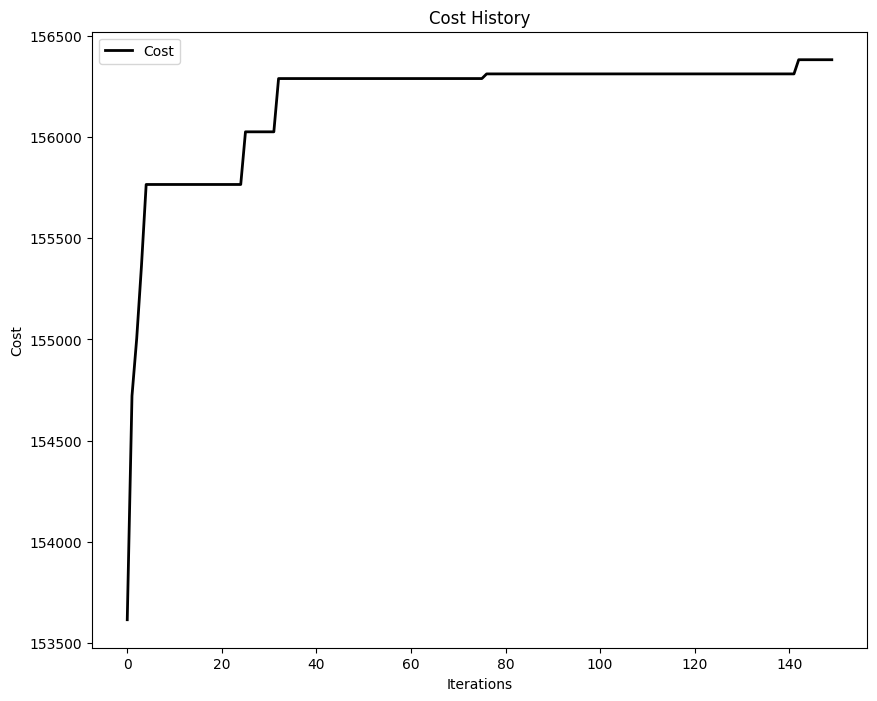

In [ ]:
resultPSO.SaveResult(result)

#### if PSO optimization has already being run and we have some inititial input wehights

Read initial position input weights 

In [30]:
#Que cantidad de particular necesito para correr el PSO:
import math 
decisionVariableArray = constraint_file['variable_splits']
n_particles =  int(10+2*math.sqrt(len(decisionVariableArray)))
n_particles

18

In [31]:
pso_date = '05.24.2024' #datetime.date.today().strftime("%m.%d.%Y")# 
fileName = base_path + f'Pos Result {pso_date}.csv' 
pos_df = pd.read_csv(fileName).drop('Unnamed: 0', axis = 1) # read the pso result file to get the input weights
inputWeights =np.tile(pos_df.pos.to_numpy(), [n_particles, 1]) # create the input weights parameters


run_pso method of SavantPSO class function, with PSO hyper parameters and input weights as initial position

In [ ]:
result = resultPSO.run_pso(options, n_particles=n_particles, itNum = itNum , init_pos=inputWeights)


2024-05-24 16:10:12,662 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.20255337412386598, 'c2': 0.034812002156869526, 'w': 0.8707709059066462}


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/ca/1 June Update/Input Weight History 05.24.2024.csv


pyswarms.single.global_best:   0%|          |0/50

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -156739.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -156739.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -156739.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -156739.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.-------

pyswarms.single.global_best:   2%|▏         |1/50, best_cost=-1.57e+5

yhat: -156739.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152354.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152531.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153217.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153734.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:   4%|▍         |2/50, best_cost=-1.57e+5

yhat: -151998.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155168.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154585.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152949.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152856.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:   6%|▌         |3/50, best_cost=-1.57e+5

yhat: -153000.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153902.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154947.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151029.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155460.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:   8%|▊         |4/50, best_cost=-1.57e+5

yhat: -154149.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153485.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154442.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155093.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153923.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  10%|█         |5/50, best_cost=-1.57e+5

yhat: -153324.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153516.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154137.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153051.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153305.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=-1.57e+5

yhat: -153886.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154729.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153365.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152099.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152925.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=-1.57e+5

yhat: -153764.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154339.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153462.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152980.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153783.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  16%|█▌        |8/50, best_cost=-1.57e+5

yhat: -152272.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154968.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153686.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151398.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153445.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  18%|█▊        |9/50, best_cost=-1.57e+5

yhat: -154009.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154693.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154831.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151990.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153050.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  20%|██        |10/50, best_cost=-1.57e+5

yhat: -153569.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151929.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153979.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153409.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155305.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  22%|██▏       |11/50, best_cost=-1.57e+5

yhat: -151609.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152443.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152385.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153121.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  24%|██▍       |12/50, best_cost=-1.57e+5

yhat: -153081.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152766.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153371.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154763.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153244.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  26%|██▌       |13/50, best_cost=-1.57e+5

yhat: -152089.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152625.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153316.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153890.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154241.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  28%|██▊       |14/50, best_cost=-1.57e+5

yhat: -153304.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153950.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153002.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154554.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153452.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  30%|███       |15/50, best_cost=-1.57e+5

yhat: -154298.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152855.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153178.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152262.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153034.0
client_budget - analytical_spend_latest_period: 0
---

pyswarms.single.global_best:  32%|███▏      |16/50, best_cost=-1.57e+5

yhat: -154688.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152157.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153540.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154018.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154104.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  34%|███▍      |17/50, best_cost=-1.57e+5

yhat: -153508.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154231.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154414.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154934.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152733.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  36%|███▌      |18/50, best_cost=-1.57e+5

yhat: -151979.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153892.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153201.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154117.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152505.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  38%|███▊      |19/50, best_cost=-1.57e+5

yhat: -153229.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152712.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153975.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151705.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153118.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  40%|████      |20/50, best_cost=-1.57e+5

yhat: -153871.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153754.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154976.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154502.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154631.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  42%|████▏     |21/50, best_cost=-1.57e+5

yhat: -151239.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153104.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153321.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153568.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152698.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  44%|████▍     |22/50, best_cost=-1.57e+5

yhat: -153450.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152890.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155334.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152388.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154289.0
client_budget - analytical_spend_latest_period: 0
---

pyswarms.single.global_best:  46%|████▌     |23/50, best_cost=-1.57e+5

yhat: -154737.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154914.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154077.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152735.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154631.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  48%|████▊     |24/50, best_cost=-1.57e+5

yhat: -151491.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153768.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152823.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155442.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152707.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  50%|█████     |25/50, best_cost=-1.57e+5

yhat: -153532.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153575.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154503.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -151821.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153757.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  52%|█████▏    |26/50, best_cost=-1.57e+5

yhat: -154429.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152782.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154750.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153037.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -156105.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  54%|█████▍    |27/50, best_cost=-1.57e+5

yhat: -153305.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153054.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153317.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153551.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151035.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  56%|█████▌    |28/50, best_cost=-1.57e+5

yhat: -152931.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152345.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153771.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154426.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154136.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  58%|█████▊    |29/50, best_cost=-1.57e+5

yhat: -154706.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151465.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152520.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153267.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153126.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  60%|██████    |30/50, best_cost=-1.57e+5

yhat: -152442.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154995.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155648.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154047.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153826.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  62%|██████▏   |31/50, best_cost=-1.57e+5

yhat: -155137.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152050.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153201.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152682.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153761.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  64%|██████▍   |32/50, best_cost=-1.57e+5

yhat: -151165.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153570.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152839.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155597.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152987.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  80%|████████  |40/50, best_cost=-1.57e+5

yhat: -155065.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153571.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155184.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154612.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155082.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  82%|████████▏ |41/50, best_cost=-1.57e+5

yhat: -152642.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153921.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153192.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153816.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -150931.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  84%|████████▍ |42/50, best_cost=-1.57e+5

yhat: -153482.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154497.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154481.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154321.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153156.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  86%|████████▌ |43/50, best_cost=-1.57e+5

yhat: -155102.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -151589.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154529.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152182.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -154504.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  88%|████████▊ |44/50, best_cost=-1.57e+5

yhat: -152922.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154482.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153448.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153432.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154619.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  90%|█████████ |45/50, best_cost=-1.57e+5

yhat: -155057.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154003.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -152526.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153462.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153643.0
client_budget - analytical_spend_latest_period: 0
----

pyswarms.single.global_best:  92%|█████████▏|46/50, best_cost=-1.57e+5

yhat: -153290.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -155078.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154376.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154708.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152420.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best:  94%|█████████▍|47/50, best_cost=-1.57e+5

yhat: -151891.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153164.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154008.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152789.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153036.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  96%|█████████▌|48/50, best_cost=-1.57e+5

yhat: -153846.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153667.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153118.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155310.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -153108.0
client_budget - analytical_spend_latest_period: 0
------

pyswarms.single.global_best:  98%|█████████▊|49/50, best_cost=-1.57e+5

yhat: -153176.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -152819.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -154265.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: -153650.0
client_budget - analytical_spend_latest_period: 0
--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435864.0 difference between planned and forecast X:  0.0
yhat: -155124.0
client_budget - analytical_spend_latest_period: 0
-----

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-1.57e+5
2024-05-24 17:08:18,986 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -156739.0, best pos: [0.91604136 1.06416097 1.10893829 1.13552905 1.19359626 1.12765689
 1.11818526 0.74944959 1.10021054 1.02302711 0.9654163  0.94178849
 0.88992545 0.90029363 0.99504549 0.81212518 0.74449795 0.8327278 ]


yhat: -154248.0
client_budget - analytical_spend_latest_period: 0
Compute duration: 3486.325893163681


if needed cave the PSO optimization results and plot the cost through the different iterations 

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/ca/1 June Update/Pos Result 05.24.2024.csv
File generated
/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/ca/1 June Update/Iteration History 05.24.2024.csv
File exists. Please delete it first.


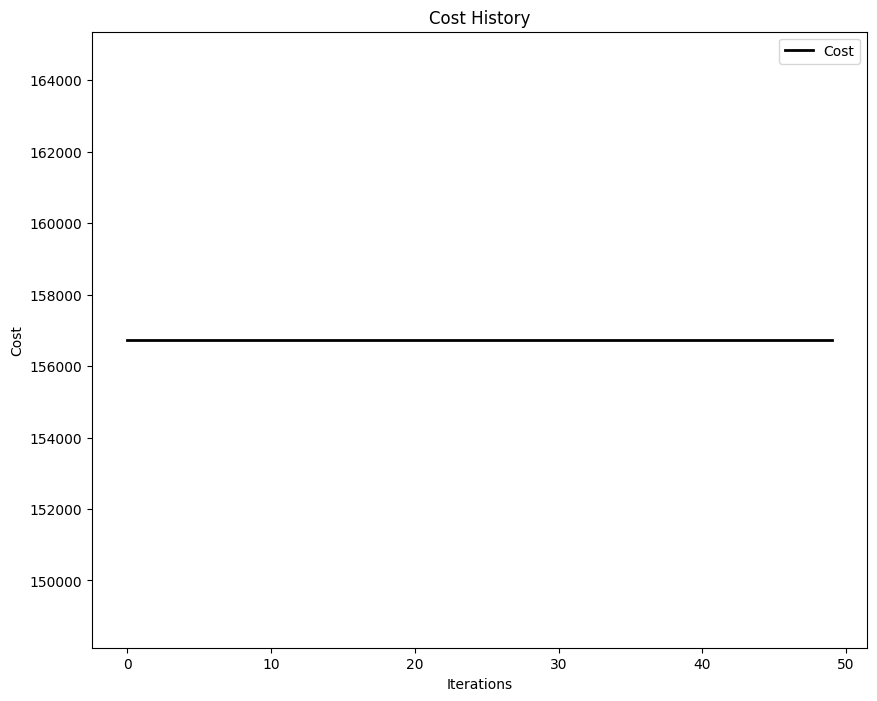

In [34]:
resultPSO.SaveResult(result)